In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

In [13]:
## reading data
## the data is pruned such that we only consider the stocks that existed across the whole 20-year period
print("reading data")


data = pd.read_csv('./data/sp500.csv')

symbol_list = list(np.load('./data/symbol_list.npy'))
pruned_data = data[data['symbol'].isin(symbol_list)]

X = torch.tensor(list(pruned_data['open'])).view(-1, len(symbol_list))
RX = torch.log(X[1:] / X[:-1]) 
symbol_list = np.sort(symbol_list)


## X is the raw data, RX is the price return
X = torch.tensor(list(pruned_data['open'])).view(-1, len(symbol_list))
RX = torch.log(X[1:] / X[:-1]) 




reading data


In [ ]:
np.save('pruned_data.npy', pruned_data)

In [9]:
symbol_list[:10]

array(['A', 'AAPL', 'ABC', 'ABT', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK',
       'AEE'], dtype='<U5')

In [11]:
## sanity check: the stock price of MSFT

print(list(np.sort(symbol_list)).index('MSFT'))
k = 230
print(X[:,k][-1000:])

230
tensor([ 48.7848,  48.9708,  48.7290,  48.3662,  48.5987,  48.3941,  48.3754,
         47.4917,  46.1241,  46.4218,  46.3102,  46.0683,  46.8963,  47.1103,
         46.7009,  47.5195,  47.7056,  46.3381,  45.6776,  45.5101,  46.4311,
         47.1847,  47.5661,  47.2870,  47.2405,  47.8359,  48.1242,  48.8406,
         49.2499,  49.8267,  50.0872,  50.1895,  49.9569,  49.9663,  52.2362,
         52.0781,  52.1711,  52.5338,  52.5804,  52.6641,  52.0966,  52.3385,
         52.6548,  52.8874,  52.7292,  52.8408,  53.6316,  54.0083,  54.1154,
         54.1060,  53.9851,  53.9851,  53.9666,  53.9303,  53.8648,  53.7524,
         53.7618,  53.9210,  54.2018,  54.1082,  54.1830,  54.5575,  54.4639,
         54.2767,  53.9678,  53.3686,  53.9865,  54.0894,  53.7992,  53.9490,
         53.1627,  52.4232,  52.8912,  52.7882,  52.5635,  53.9490,  53.6120,
         53.6869,  53.8367,  54.2205,  54.1737,  53.4342,  53.2937,  54.1831,
         54.1175,  53.8928,  53.7384,  53.6120,  53.6308,  5

In [16]:
## we use a simple neural network

class Net(nn.Module):

    def __init__(self,  p=0.2):
        super(Net, self).__init__()
        self.w = torch.nn.Linear(30, 64)
        self.w1 = torch.nn.Linear(64, 64)
        self.act = F.leaky_relu
        self.w2 = torch.nn.Linear(64, 1)
        self.d = nn.Dropout(p=p)
    def forward(self, x):
        #print(x.shape)
        x = self.act(self.w(x))
        x = self.act(self.w1(x))
        x = self.d(x)

        x = self.w2(x)

        return torch.sigmoid(x)

model = Net()

In [17]:

## minibatch sampling, we implement the data augmentation of the input prices directly into the minibatch sampling part
## though one might implement it in a more principled way

S = 64
sigma = 0.5
def minibatch(datax, datay, sigma=0):
  L = len(datax)
  idx = torch.randint(L-1, (S,)).cuda()
  x, y, r = datax[idx], datay[idx], RTNtrain[idx]
  
  if sigma>0:
    #print(r.shape)
    return x + (r.abs() ** 0.5) * (x) * torch.empty_like(x).normal_(0, sigma), y #+ (y.abs() ** 0.5) * torch.empty_like(y).normal_(0, sigma)

  return x, y

In [22]:
## Note that the second part of the proposed method (an equivalent regularization) is implemented in this training loss
def criterion(x, y, lbd, X, sigma):
  
  r = ((X[:, 10:] - X[:, 9:-1])/(X[:, 9:-1]))
  return -(wealth_gain(x,y) -  (sigma ** 2) * lbd * (r.abs().mean(dim=1).unsqueeze(1)) *  (x **2)).mean()


In [23]:
## other useful functions


## we allow a non-zero interest rate, though this result is not studied in the manuscript
INTEREST = 0
def sharpe(X):
  X = np.array(X)
  ri = (X[1:] / X[:-1]) -1
  return ((ri).mean() - INTEREST)/(np.std(ri)) * np.sqrt(252)



def wealth_gain(x, y):
    return x * y  + (1 - x) * INTEREST



def train(X,Y, criterion, f, opt, sigma, lbd, minibatch):
  train_loss = 0
  for itr in range(1):
    x, y = minibatch(X, Y, sigma)
    y_pred = f(x)
    loss = criterion(y_pred, y, lbd, x, sigma)  
    opt.zero_grad()  
    loss.backward()
    opt.step()
  return 0 


In [25]:
wealth_trajs = []
results = []

## processing data
print("processing data")
k = 230
prices = X[:,k][-1000:] / X[:,k][-1000:].std()

## we construct the portfolio based on the prices of the previous 30 days
input_size = 30
prices = torch.tensor(prices).float()
fullX = torch.stack([prices[i-input_size: i] for i in range(input_size, len(prices))])
fullX = fullX[:-1]#.transpose(0, 1)
Y = ((prices[1:] - prices[:-1]) / prices[:-1])[input_size:]#.transpose(0, 1)
fullRTN = ((prices[1:] - prices[:-1]) / prices[:-1])#.transpose(0, 1)
fullRTN = torch.stack([fullRTN[i-input_size: i] for i in range(input_size, len(fullRTN))])#.transpose(2, 1).transpose(0, 1)
fullX = fullX.cuda()
Y = Y.cuda().unsqueeze(1)
fullRTN = fullRTN.cuda()
num_test = 2000
Xtrain = fullX[:800]
Ytrain = Y[:800]
Xtest = fullX[800:]
Ytest = Y[800:]
RTNtrain = fullRTN[:800]
meanout =  Ytrain.mean(dim=0)


## training

losses = []
STEP = 5000
sigma = 1

f_aug = Net(p=0).cuda()
optimizer = torch.optim.Adam(f_aug.parameters(), lr=1e-4, weight_decay=decay)
ours_sigma =  1

for i in range (STEP):
  if False:
    portfolio_train = f_aug(Xtrain).squeeze(1)
    plt.plot(fullX[:800, -1].cpu() /20, label='price')
    plt.plot(portfolio_train.detach().cpu(), label='portfolio')
    plt.show()
    plt.close()

  loss2 = train(Xtrain,Ytrain,criterion,f_aug,optimizer, sigma= 0.5 *ours_sigma, lbd=1, minibatch=minibatch)


## training finished
print("training finished")

    



processing data


/tmp/ipykernel_20570/3669477374.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prices = torch.tensor(prices).float()


training finished


In [26]:
## testing
model.eval()
portfolio = f_aug(Xtest).squeeze(1)
print("average portfolio position: ", portfolio.sum().item())
DeltaW = 1 + (wealth_gain(portfolio, Ytest.squeeze(1))).T.detach().cpu().numpy() 
size = 2
Wealth_trajectory = [np.ones(size-1)]
for i in range(len(DeltaW)):
  Wealth_trajectory.append(Wealth_trajectory[-1] * DeltaW[i])
message = "results," + symbol_list[k] + ',' + str(sharpe(Wealth_trajectory))  + '\n'
print("results: ", symbol_list[k], sharpe(Wealth_trajectory))

average portfolio position:  0.7368746995925903
results:  MSFT 2.34818943070356


/tmp/ipykernel_20570/1844912502.py:5: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352616446/work/aten/src/ATen/native/TensorShape.cpp:2985.)
  DeltaW = 1 + (wealth_gain(portfolio, Ytest.squeeze(1))).T.detach().cpu().numpy()


Text(0.5, 1.0, 'learned portfolio')

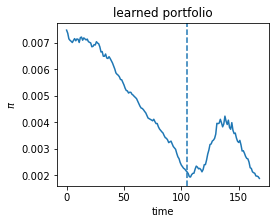

In [27]:
plt.figure(figsize=(3.8, 3))

plt.plot(portfolio.cpu().detach())
plt.xlabel('time')
plt.axvline(x=105, linestyle='--')
plt.ylabel(r'$\pi$')
plt.title('learned portfolio')
#plt.savefig("case_study_portfolio.png", dpi=150, bbox_inches='tight')

Text(0.5, 1.0, 'stock')

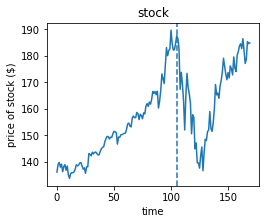

In [29]:
plt.figure(figsize=(3.8, 3))

plt.plot((prices[830:] * X[:,k][-1000:].std()).cpu().detach())
plt.axvline(x=105, linestyle='--')

plt.ylabel('price of stock ($)')
plt.xlabel('time')
plt.title('stock')
#plt.savefig("case_study_price.png", dpi=150, bbox_inches='tight')

